In [1]:
# Load in our libraries
import re
import sklearn
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import plotly.tools as tls
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline
py.init_notebook_mode(connected=True)

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,\
    GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;

D:\Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [2]:
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
814,815,0,3,"Tomlin, Mr. Ernest Portage",male,30.5,0,0,364499,8.050,NaN,S
307,308,1,1,"Penasco y Castellana, Mrs. Victor de Satode (M...",female,17.0,1,0,PC 17758,108.900,C65,C
742,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.375,B57 B59 B63 B66,C


In [3]:
# Feature engineering
full_data = [train, test]

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# Create a new feature Title, containing the titles of passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major',\
                                                 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']                               = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare']                                  = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age']                          = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4;

<input>:40: DeprecationWarning:

invalid escape sequence \.

<input>:40: DeprecationWarning:

invalid escape sequence \.

<input>:40: DeprecationWarning:

invalid escape sequence \.

<input>:40: DeprecationWarning:

invalid escape sequence \.

<input>:40: DeprecationWarning:

invalid escape sequence \.

<input>:40: DeprecationWarning:

invalid escape sequence \.

<input>:40: DeprecationWarning:

invalid escape sequence \.

<input>:40: DeprecationWarning:

invalid escape sequence \.

<input>:40: DeprecationWarning:

invalid escape sequence \.

<input>:40: DeprecationWarning:

invalid escape sequence \.

<input>:40: DeprecationWarning:

invalid escape sequence \.

<input>:40: DeprecationWarning:

invalid escape sequence \.

<input>:40: DeprecationWarning:

invalid escape sequence \.

<input>:40: DeprecationWarning:

invalid escape sequence \.

<input>:40: DeprecationWarning:

invalid escape sequence \.

<input>:40: DeprecationWarning:

invalid escape sequence \.

<input>:40: DeprecationW

In [4]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)
train.sample(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
158,0,3,1,1,0,1,0,19,0,1,1,1
291,1,1,0,1,0,3,1,39,1,2,0,3
306,1,1,0,2,0,3,1,23,0,1,1,2


D:\Anaconda\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning:

elementwise == comparison failed; this will raise an error in the future.

D:\Anaconda\lib\site-packages\seaborn\matrix.py:151: DeprecationWarning:

elementwise == comparison failed; this will raise an error in the future.



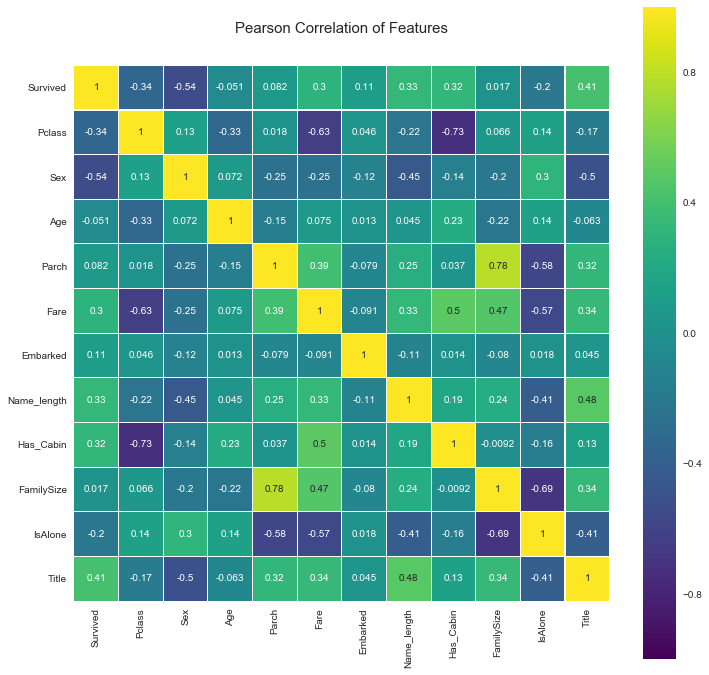

In [5]:
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True,\
            cmap=plt.cm.viridis, linecolor='white', annot=True)

D:\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning:

object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.

D:\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning:

invalid value encountered in true_divide

D:\Anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars

D:\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning:

object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.

D:\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning:

object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.

D:\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning:

object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.

D:\Anaconda\lib\site-packages\statsmodels\nonpa

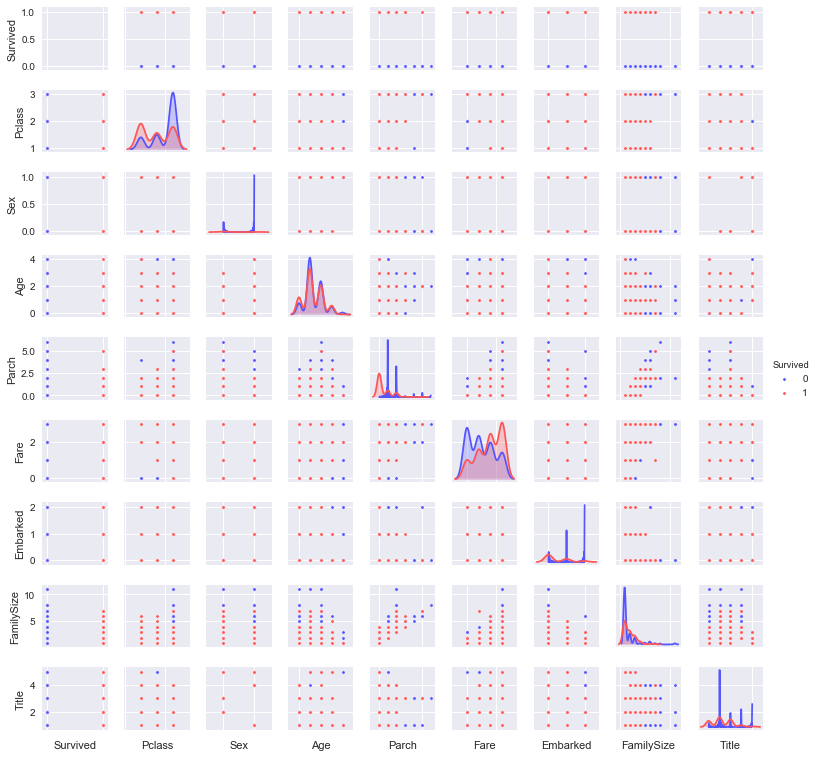

In [6]:
sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
                    u'FamilySize', u'Title']], hue='Survived', palette='seismic',size=1.2,
                    diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10)).set(xticklabels=[])

In [7]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    def predict(self, x):
        return self.clf.predict(x)    
    def fit(self,x,y):
        return self.clf.fit(x,y)    
    def feature_importances(self,x,y):
        return(self.clf.fit(x,y).feature_importances_)

In [8]:
# Get Out-of-Fold Predictions
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.zeros((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        clf.train(x_tr, y_tr)
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [9]:
# Put in our parameters for said classifiers

# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}

In [10]:
# Create 5 objects that represent our models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [11]:
# Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [12]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:303: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.



In [13]:
rf_features = rf.feature_importances(x_train, y_train)
et_features = et.feature_importances(x_train, y_train)
ada_features = ada.feature_importances(x_train, y_train)
gb_features = gb.feature_importances(x_train,y_train)
# svc_feature = svc.feature_importances(x_train, y_train) no such attribute

D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:303: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.



In [14]:
# Create a dataframe with features
feature_dataframe = pd.DataFrame({'features': train.columns.values,
     'Random Forest feature importances': rf_features,
     'Extra Trees feature importances': et_features,
     'AdaBoost feature importances': ada_features,
     'Gradient Boost feature importances': gb_features
})

In [15]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [16]:
# Create the new column containing the average of values
feature_dataframe['mean'] = feature_dataframe.mean(axis=1)
feature_dataframe

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.028,0.119687,0.078179,0.125900,Pclass,0.087941
1,0.008,0.378997,0.034100,0.198291,Sex,0.154847
2,0.014,0.029773,0.094186,0.032622,Age,0.042645
3,0.062,0.017212,0.025467,0.021052,Parch,0.031433
4,0.038,0.056102,0.099135,0.072221,Fare,0.066364
5,0.010,0.028689,0.049748,0.023773,Embarked,0.028053
6,0.702,0.046952,0.424744,0.108528,Name_length,0.320556
7,0.012,0.083949,0.020834,0.065045,Has_Cabin,0.045457
8,0.052,0.043831,0.068541,0.066652,FamilySize,0.057756
9,0.006,0.021716,0.019922,0.014005,IsAlone,0.015411


In [17]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

In [18]:
base_predictions_train = pd.DataFrame({'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
     'GradientBoost': gb_oof_train.ravel(),
     'SVC': svc_oof_train.ravel()
    })
base_predictions_test = pd.DataFrame({'RandomForest': rf_oof_test.ravel(),
     'ExtraTrees': et_oof_test.ravel(),
     'AdaBoost': ada_oof_test.ravel(),
     'GradientBoost': gb_oof_test.ravel(),
     'SVC': svc_oof_test.ravel()
    })

In [19]:
py.iplot([go.Heatmap(x=base_predictions_train.columns.values,
                     y=base_predictions_train.columns.values,
                     z=base_predictions_train.astype(float).corr().values,
                     colorscale='Portland', showscale=True, reversescale=True)])

In [20]:
predictions = xgb.XGBClassifier(
    # learning_rate=.02
    n_estimators=2000,
    max_depth=4,
    min_child_weight=2,
    gamma=.9,                        
    subsample=.7,
    colsample_bytree=.7,
    objective='binary:logistic',
    nthread=-1,
    num_round=1000,
    scale_pos_weight=1).fit(base_predictions_train, y_train).predict(base_predictions_test)

In [21]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId, 'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)
base_predictions_train['Survived'] = y_train
base_predictions_train.to_csv("restrain.csv", index=False)
base_predictions_test.to_csv("restest.csv", index=False)